In [ ]:
fmow_dataset_path = "/Code/Datasets/fMoW/train"

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import time
import numpy as np
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import os
from glob import glob
import os
import PIL.Image
import math
from torchvision.transforms.functional import pil_to_tensor
from sklearn.metrics import recall_score, precision_score, accuracy_score
from tqdm.notebook import tqdm

In [2]:
PIL.Image.MAX_IMAGE_PIXELS = 1909056320
labels = ["airport", "golf_course", "shipyard", "stadium", "wind_farm"]

def load_wilds(path, sample_per_label = 450, training_percent = 0.8):
    if not os.path.isdir(path):
        raise Exception(f"{path} path does not exist")
    
    label_dict = {}

    for label in tqdm(labels):
        label_dict[label] = []
        for i in tqdm(range(sample_per_label)):
            if not os.path.isdir(f'{path}/{label}/{label}_{i}'):
                continue
                                 
            j = 0
            while True:
                file_path = f'{path}/{label}/{label}_{i}/{label}_{i}_{j}_msrgb.jpg'
                
                if os.path.isfile(file_path) == True:
                    break
                else:
                    j = j + 1
                
            label_dict[label].append(PIL.Image.open(file_path).resize(size=(224, 224)))

    train_ds = []
    eval_ds = []

    for label in labels:
        train_count = math.floor(len(label_dict[label]) * training_percent)
        test_count = len(label_dict[label]) - train_count

        for i in range(train_count):
            if i < len(label_dict[label]):
                train_ds.append({"image": label_dict[label][i], "label": label, "y": labels.index(label)})
            else:
                print(f"Only {i} train samples for {label}")
                break

        for i in range(train_count, train_count + test_count):
            if i < len(label_dict[label]):
                eval_ds.append({"image": label_dict[label][i], "label": label, "y": labels.index(label)})
            else:
                print(f"Only {i} eval samples for {label}")
                break

    return pd.DataFrame(train_ds), pd.DataFrame(eval_ds)

train_df, eval_df = load_wilds(fmow_dataset_path)
display(train_df)
display(eval_df)



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

,image,label,y
0,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
1,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
2,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
3,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
4,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
...,...,...,...
1515,<PIL.Image.Image image mode=RGB size=224x224 a...,wind_farm,4
1516,<PIL.Image.Image image mode=RGB size=224x224 a...,wind_farm,4
1517,<PIL.Image.Image image mode=RGB size=224x224 a...,wind_farm,4
1518,<PIL.Image.Image image mode=RGB size=224x224 a...,wind_farm,4


,image,label,y
0,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
1,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
2,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
3,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
4,<PIL.Image.Image image mode=RGB size=224x224 a...,airport,0
...,...,...,...
378,<PIL.Image.Image image mode=RGB size=224x224 a...,wind_farm,4
379,<PIL.Image.Image image mode=RGB size=224x224 a...,wind_farm,4
380,<PIL.Image.Image image mode=RGB size=224x224 a...,wind_farm,4
381,<PIL.Image.Image image mode=RGB size=224x224 a...,wind_farm,4


In [3]:
# Loading the .csv into the dataset

class fMoWDataset(Dataset):
    def __init__(self, df):
        super().__init__()

        self.df = df

        self.y = df.iloc[:, 2]

        df = df.apply(lambda row: pil_to_tensor(row["image"]), axis=1)
        self.x = torch.stack(df.tolist(), dim=0)
        
        self.x = torch.tensor(self.x, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.long)

        self.x /= 255.0
        # self.x = F.interpolate(self.x, size=(224, 224), mode='bilinear', antialias=True)
        print(self.y.shape)
        print(self.x.shape)
        
    def shape(self):
        return self.x.shape

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

eval_ds = fMoWDataset(eval_df)
train_ds = fMoWDataset(train_df)

/tmp/ipykernel_31444/3166376378.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(self.x, dtype=torch.float32)


torch.Size([383])
torch.Size([383, 3, 224, 224])
torch.Size([1520])
torch.Size([1520, 3, 224, 224])


/tmp/ipykernel_31444/3166376378.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(self.x, dtype=torch.float32)


array([[<Axes: title={'center': 'y'}>]], dtype=object)

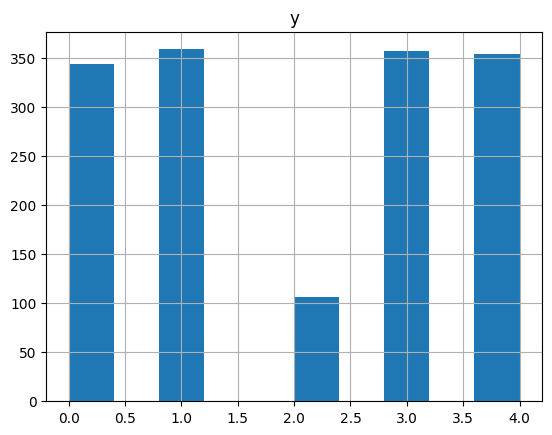

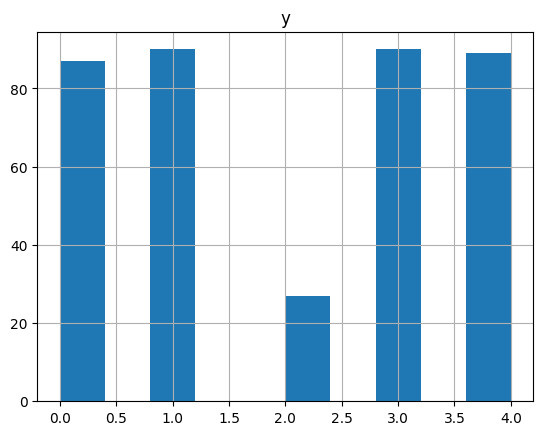

In [4]:
train_df.hist(column = 'y')
eval_df.hist(column = 'y')

In [5]:
train_loader = DataLoader(train_ds, batch_size=10, shuffle=True)
test_loader = DataLoader(eval_ds, batch_size=10, shuffle=False)

torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5, 3, 224, 224])
    airport      golf_course      shipyard      stadium      wind_farm


/tmp/ipykernel_31444/3166376378.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(self.x, dtype=torch.float32)


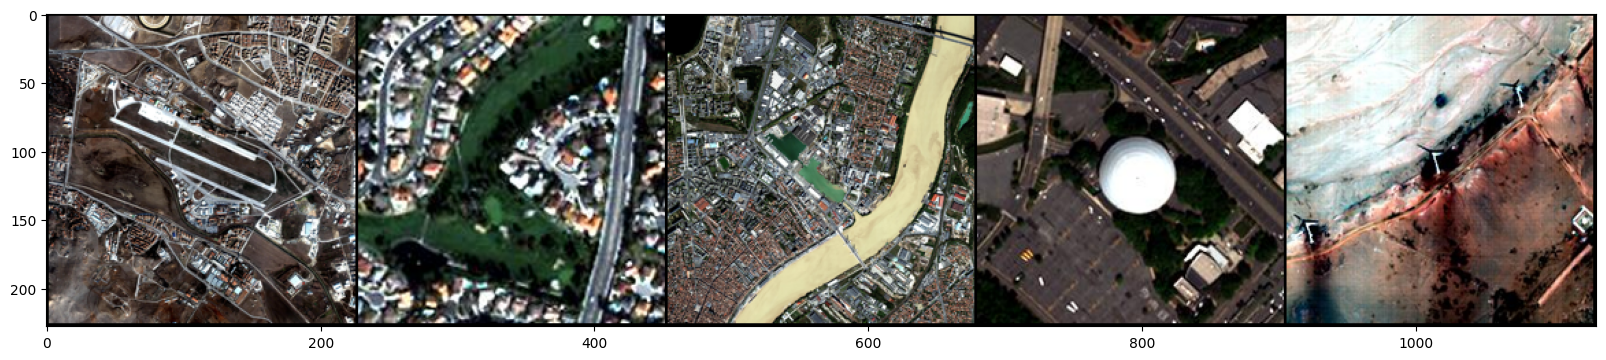

In [6]:
first_df = train_df.groupby('label', as_index=False).first()
first_dataset = fMoWDataset(first_df)

images, l = first_dataset[:]
print(images.shape)

im = make_grid(images, nrow=len(first_df))
plt.figure(figsize=(20,8))
plt.imshow(np.transpose(im.numpy(),(1, 2, 0)))

labels_string = "      ".join(labels)
print("    " + labels_string)

In [7]:
# Defining the network architecture
BACKBONE_SIZE = "giant" # in ("small", "base", "large" or "giant")

backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}

backbone_size = {
    "small": 384,
    "base": 768,
    "large": 1024,
    "giant": 1536 
}

class fMoWModel(nn.Module):
    
    def __init__(self, dir=None):       
        super().__init__()
        self.backbone_arch = backbone_archs[BACKBONE_SIZE]
        self.backbone_name = f"dinov2_{self.backbone_arch}"

        self.fc1 = nn.Linear(in_features=backbone_size[BACKBONE_SIZE], out_features=len(labels))
        #self.fc2 = nn.Linear(in_features=512, out_features=128)
        #self.fc3 = nn.Linear(in_features=128, out_features=26)
        
        if dir != None:
            self.backbone_model = torch.hub.load(repo_or_dir='facebookresearch/dinov2', model=self.backbone_name, pretrained=False)
            self.load_state_dict(torch.load(dir))
        else:
            self.backbone_model = torch.hub.load(repo_or_dir='facebookresearch/dinov2', model=self.backbone_name, pretrained=True)
            
        for param in self.backbone_model.parameters():
            param.requires_grad = False

        self.backbone_model.eval()
        self.backbone_model.cuda()
        
    def forward(self, X):
        X = self.backbone_model(X)  
        #X = F.relu(self.fc1(X))
        #X = F.relu(self.fc2(X))
        
        return F.log_softmax(input=self.fc1(X), dim=1)  

In [8]:
# Training the model
epochs = 10

writer = SummaryWriter('fMoWLog')

model = fMoWModel()
model = model.cuda()

start_time = time.time()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []
accuracy_graph = []
precision_graph = []
recall_graph = []

for i in range(epochs):
    tst_corr = 0
    trn_corr = 0

    for b, (X_train, y_train) in tqdm(enumerate(train_loader)):
        b += 1
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%28 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/{len(train_df)}]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
    
    writer.add_scalar("Loss/train", loss, i)     
    train_losses.append(loss.cpu().detach().numpy())
    

    # Test model per epoch
    model.eval()
    y_true_label = []
    predictions = []
    
    with torch.no_grad():
        for b, (X_test, y_test) in tqdm(enumerate(test_loader)):
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
            writer.add_scalar("accuracy/test", tst_corr, i)
            
            y_true_label.extend(y_test.cpu().detach().numpy())
            predictions.extend(predicted.cpu().detach().numpy())
    
    accuracy = accuracy_score(y_true_label, predictions)
    precision = precision_score(y_true_label, predictions, average="macro")
    recall = recall_score(y_true_label, predictions, average="macro")

    accuracy_graph.append(accuracy)
    precision_graph.append(precision)
    recall_graph.append(recall)

    model.train()
    loss = criterion(y_val,y_test)
    test_losses.append(loss.cpu().detach().numpy())
    print(f'test accuracy: {accuracy*100:7.2f}, precision: {precision*100:7.2f}, recall: {recall*100:7.2f}')
    torch.save(model.state_dict(), f"fMoWEpoch/fMoW_Epoch_{i}.pt")
    
total_time = time.time() - start_time
print(f'\nDuration: {total_time:.0f} seconds')

Using cache found in /home/azureuser/.cache/torch/hub/facebookresearch_dinov2_main
/home/azureuser/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/azureuser/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/azureuser/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


0it [00:00, ?it/s]

/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


epoch:  0  batch:   28 [   280/1520]  loss: 0.38893384  accuracy:  78.929%
epoch:  0  batch:   56 [   560/1520]  loss: 0.09105129  accuracy:  85.714%
epoch:  0  batch:   84 [   840/1520]  loss: 0.02968731  accuracy:  87.857%
epoch:  0  batch:  112 [  1120/1520]  loss: 0.13396023  accuracy:  89.196%
epoch:  0  batch:  140 [  1400/1520]  loss: 0.18102053  accuracy:  89.500%


0it [00:00, ?it/s]

test accuracy:   92.17, precision:   93.64, recall:   86.57


0it [00:00, ?it/s]

/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


epoch:  1  batch:   28 [   280/1520]  loss: 0.19905797  accuracy:  94.286%
epoch:  1  batch:   56 [   560/1520]  loss: 0.03135799  accuracy:  94.821%
epoch:  1  batch:   84 [   840/1520]  loss: 0.13533926  accuracy:  95.476%
epoch:  1  batch:  112 [  1120/1520]  loss: 0.16527775  accuracy:  95.357%
epoch:  1  batch:  140 [  1400/1520]  loss: 0.03673160  accuracy:  95.429%


0it [00:00, ?it/s]

test accuracy:   94.78, precision:   94.37, recall:   95.50


0it [00:00, ?it/s]

/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


epoch:  2  batch:   28 [   280/1520]  loss: 0.21709684  accuracy:  98.571%
epoch:  2  batch:   56 [   560/1520]  loss: 0.05318953  accuracy:  97.500%
epoch:  2  batch:   84 [   840/1520]  loss: 0.11264198  accuracy:  97.619%
epoch:  2  batch:  112 [  1120/1520]  loss: 0.03916711  accuracy:  97.679%
epoch:  2  batch:  140 [  1400/1520]  loss: 0.00443308  accuracy:  97.500%


0it [00:00, ?it/s]

test accuracy:   95.56, precision:   95.24, recall:   95.67


0it [00:00, ?it/s]

/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


epoch:  3  batch:   28 [   280/1520]  loss: 0.00765398  accuracy:  98.214%
epoch:  3  batch:   56 [   560/1520]  loss: 0.00668007  accuracy:  98.036%
epoch:  3  batch:   84 [   840/1520]  loss: 0.00423495  accuracy:  97.976%
epoch:  3  batch:  112 [  1120/1520]  loss: 0.00670456  accuracy:  98.125%
epoch:  3  batch:  140 [  1400/1520]  loss: 0.06823347  accuracy:  98.214%


0it [00:00, ?it/s]

test accuracy:   95.04, precision:   95.21, recall:   93.17


0it [00:00, ?it/s]

/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


epoch:  4  batch:   28 [   280/1520]  loss: 0.01552957  accuracy:  97.857%
epoch:  4  batch:   56 [   560/1520]  loss: 0.02133060  accuracy:  98.393%
epoch:  4  batch:   84 [   840/1520]  loss: 0.00614605  accuracy:  98.571%
epoch:  4  batch:  112 [  1120/1520]  loss: 0.00432306  accuracy:  98.661%
epoch:  4  batch:  140 [  1400/1520]  loss: 0.13996543  accuracy:  98.500%


0it [00:00, ?it/s]

test accuracy:   96.34, precision:   95.90, recall:   96.35


0it [00:00, ?it/s]

/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


epoch:  5  batch:   28 [   280/1520]  loss: 0.00548109  accuracy:  99.643%
epoch:  5  batch:   56 [   560/1520]  loss: 0.00396174  accuracy:  99.643%
epoch:  5  batch:   84 [   840/1520]  loss: 0.01663150  accuracy:  99.286%
epoch:  5  batch:  112 [  1120/1520]  loss: 0.01232718  accuracy:  98.839%
epoch:  5  batch:  140 [  1400/1520]  loss: 0.02658626  accuracy:  99.000%


0it [00:00, ?it/s]

test accuracy:   93.47, precision:   94.05, recall:   91.84


0it [00:00, ?it/s]

/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


epoch:  6  batch:   28 [   280/1520]  loss: 0.09916227  accuracy:  98.214%
epoch:  6  batch:   56 [   560/1520]  loss: 0.00023639  accuracy:  98.750%
epoch:  6  batch:   84 [   840/1520]  loss: 0.00579684  accuracy:  98.929%
epoch:  6  batch:  112 [  1120/1520]  loss: 0.13736017  accuracy:  98.929%
epoch:  6  batch:  140 [  1400/1520]  loss: 0.00495576  accuracy:  98.857%


0it [00:00, ?it/s]

test accuracy:   94.26, precision:   94.35, recall:   94.04


0it [00:00, ?it/s]

/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


epoch:  7  batch:   28 [   280/1520]  loss: 0.00104462  accuracy:  97.857%
epoch:  7  batch:   56 [   560/1520]  loss: 0.04523739  accuracy:  98.571%
epoch:  7  batch:   84 [   840/1520]  loss: 0.08126715  accuracy:  98.810%
epoch:  7  batch:  112 [  1120/1520]  loss: 0.00764260  accuracy:  98.839%
epoch:  7  batch:  140 [  1400/1520]  loss: 0.00271978  accuracy:  99.071%


0it [00:00, ?it/s]

test accuracy:   96.34, precision:   95.89, recall:   96.35


0it [00:00, ?it/s]

/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


epoch:  8  batch:   28 [   280/1520]  loss: 0.01322415  accuracy: 100.000%
epoch:  8  batch:   56 [   560/1520]  loss: 0.01735826  accuracy: 100.000%
epoch:  8  batch:   84 [   840/1520]  loss: 0.00017856  accuracy: 100.000%
epoch:  8  batch:  112 [  1120/1520]  loss: 0.00446926  accuracy:  99.821%
epoch:  8  batch:  140 [  1400/1520]  loss: 0.01892966  accuracy:  99.786%


0it [00:00, ?it/s]

test accuracy:   95.56, precision:   95.23, recall:   95.67


0it [00:00, ?it/s]

/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


epoch:  9  batch:   28 [   280/1520]  loss: 0.00348506  accuracy: 100.000%
epoch:  9  batch:   56 [   560/1520]  loss: 0.00520223  accuracy: 100.000%
epoch:  9  batch:   84 [   840/1520]  loss: 0.02819499  accuracy: 100.000%
epoch:  9  batch:  112 [  1120/1520]  loss: 0.00232165  accuracy:  99.911%
epoch:  9  batch:  140 [  1400/1520]  loss: 0.00078662  accuracy:  99.857%


0it [00:00, ?it/s]

test accuracy:   95.30, precision:   94.96, recall:   94.94

Duration: 4152 seconds


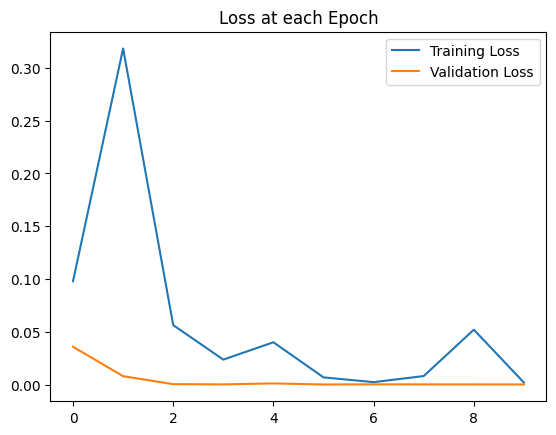

In [9]:
plt.plot(train_losses, label= 'Training Loss')
plt.plot(test_losses, label= 'Validation Loss')
plt.title('Loss at each Epoch')
plt.legend()

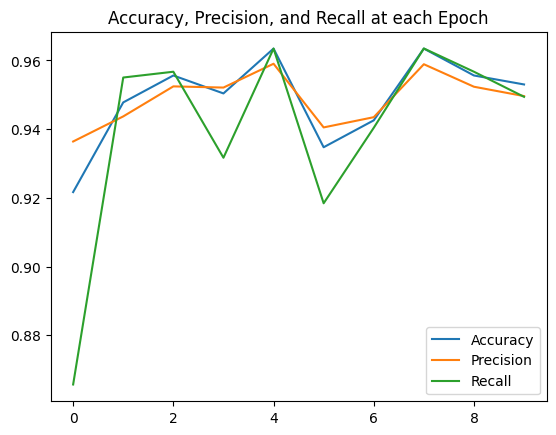

In [10]:
plt.plot(accuracy_graph, label= 'Accuracy')
plt.plot(precision_graph, label= 'Precision')
plt.plot(recall_graph, label='Recall')
plt.title('Accuracy, Precision, and Recall at each Epoch')
plt.legend()


In [14]:
if "model" in globals():
    del model.backbone_model
    del model
torch.cuda.empty_cache()

model = fMoWModel("fMoWEpoch/fMoW_Epoch_7.pt")
model = model.cuda()
model.eval()

Using cache found in /home/azureuser/.cache/torch/hub/facebookresearch_dinov2_main


fMoWModel(
  (fc1): Linear(in_features=1536, out_features=5, bias=True)
  (backbone_model): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-39): 40 x NestedTensorBlock(
        (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1536, out_features=4608, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1536, out_features=1536, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (mlp): SwiGLUFFNFused(
          (w12): Linear(in_features=1536, out_features=8192, bias=True)
          (w3): Linear(in_features=4096, out_features=1536, bias=True)
        )
       

In [15]:
y_true_label = []
predictions = []
test_load_all = DataLoader(eval_ds, batch_size=10, shuffle=False)

with torch.no_grad():
    correct = 0
    for b, (X_test, y_test) in tqdm(enumerate(test_load_all)):
        y_val = model(X_test.cuda())
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test.cuda()).sum()
        y_true_label.extend(y_test.cpu().detach().numpy())
        predictions.extend(predicted.cpu().detach().numpy())

print(f'Test Accuracy: {correct.item()/len(eval_df)*100:.2f}%')

0it [00:00, ?it/s]

/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/Code/conda/dinov2/lib/python3.9/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


Test Accuracy: 96.34%


['airport', 'golf_course', 'shipyard', 'stadium', 'wind_farm']


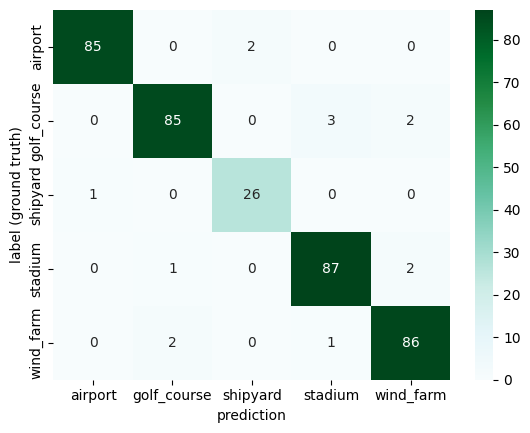

In [17]:
confusion_names = labels.copy()
print(confusion_names)
arr = confusion_matrix(y_true_label, predictions)
df_cm = pd.DataFrame(arr, confusion_names, confusion_names)
plt.figure()
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [ ]:
pred = labels.index('X')
lbl = labels.index('T')
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] == pred and y_test[i] == lbl:
        misses = np.append(misses,i).astype('int64')
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))
r = 24
row = iter(np.array_split(misses,len(misses)//r+1))
nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([labels[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([labels[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(24,24))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

